In [1]:
# Import necessary libraries
import os
import time
import math
import copy
import random
import numpy as np
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Subset
from torch.amp import autocast, GradScaler
from LSTM import LSTMModel
from CNN_LSTM import CNNLSTMModel
from Transformer import TransformerModel
import matplotlib.pyplot as plt

In [2]:
# Load cleaned data from CSV
input_path = "world_bank_data_clean.csv"
world_bank_data = pd.read_csv(input_path)

In [3]:
# Selecting features and target variable
numeric_cols = [col for col in world_bank_data.columns 
               if col not in ['country', 'date', 'year']]

target_col = 'GDPpc_2017$'  # We forecast GDP per capita for the next 5 years

In [4]:
# Preprocessing data for time series analysis
input_window = 10
output_window = 5

RANDOM_STATE = 42

# To enforce true consecutive years
ENFORCE_CONSECUTIVE_YEARS = True

def is_consecutive(years: np.ndarray) -> bool:
    return np.all(np.diff(years) == 1)

# Build windows X, y (+ country labels for stratification)
X, y, countries_win, end_year_win, start_year_win = [], [], [], [], []

for country in world_bank_data["country"].unique():
    df = (world_bank_data[world_bank_data["country"] == country]
          .sort_values("year")
          .reset_index(drop=True))

    years = df["year"].to_numpy()

    for i in range(len(df) - input_window - output_window + 1):
        in_years  = years[i : i + input_window]
        out_years = years[i + input_window : i + input_window + output_window]

        if ENFORCE_CONSECUTIVE_YEARS:
            if (not is_consecutive(in_years)) or (not is_consecutive(out_years)) or (out_years[0] != in_years[-1] + 1):
                continue

        X_win = df.iloc[i : i + input_window][numeric_cols].to_numpy()
        y_win = df.iloc[i + input_window : i + input_window + output_window][target_col].to_numpy()  # (5,)

        X.append(X_win)
        y.append(y_win)
        countries_win.append(country)
        start_year_win.append(in_years[0])
        end_year_win.append(out_years[-1])  # key for "how far into the future" this sample goes

X = np.array(X)                    # (n_samples, 10, 10)
y = np.array(y)                    # (n_samples, 5)
countries_win = np.array(countries_win)  # (n_samples,)
start_year_win = np.array(start_year_win) # (n_samples,)
end_year_win = np.array(end_year_win) # (n_samples,)

print("Built windows:")
print("X:", X.shape, "y:", y.shape, "countries_win:", countries_win.shape, "start_year_win:", start_year_win.shape, "end_year_win:", end_year_win.shape)

Built windows:
X: (6570, 10, 10) y: (6570, 5) countries_win: (6570,) start_year_win: (6570,) end_year_win: (6570,)


In [5]:
VAL_YEARS  = 4
TEST_YEARS = 5

out_start_year_win = end_year_win - (output_window - 1)  # first year in y

max_out_start = out_start_year_win.max()                 # should be 2019
TEST_START = max_out_start - TEST_YEARS + 1              # 2015
VAL_START  = TEST_START - VAL_YEARS                      # 2011

train_mask = out_start_year_win < VAL_START
val_mask   = (out_start_year_win >= VAL_START) & (out_start_year_win < TEST_START)
test_mask  = out_start_year_win >= TEST_START

train_idx = np.where(train_mask)[0]
val_idx   = np.where(val_mask)[0]
test_idx  = np.where(test_mask)[0]

X_train, y_train = X[train_idx], y[train_idx]
X_val,   y_val   = X[val_idx],   y[val_idx]
X_test,  y_test  = X[test_idx],  y[test_idx]

# sanity
assert out_start_year_win[train_idx].max() < VAL_START
assert out_start_year_win[val_idx].min() >= VAL_START
assert out_start_year_win[val_idx].max() < TEST_START
assert out_start_year_win[test_idx].min() >= TEST_START

In [6]:
# StandardScaler (fit on TRAIN only), then transform all
scaler_X = StandardScaler()
scaler_y = StandardScaler()

scaler_X.fit(X_train.reshape(-1, X_train.shape[-1]))  # (n_train*10, 10)
scaler_y.fit(y_train.reshape(-1, 1))                  # (n_train*5, 1)

def scale_X(a):
    return scaler_X.transform(a.reshape(-1, a.shape[-1])).reshape(a.shape)

def scale_y(a):
    return scaler_y.transform(a.reshape(-1, 1)).reshape(a.shape)

X_train_s, X_val_s, X_test_s = scale_X(X_train), scale_X(X_val), scale_X(X_test)
y_train_s, y_val_s, y_test_s = scale_y(y_train), scale_y(y_val), scale_y(y_test)

In [7]:
# Print shapes and percentages of the data splits
n_train, n_val, n_test = len(X_train_s), len(X_val_s), len(X_test_s)
n_total = n_train + n_val + n_test

print("VAL_START:", VAL_START, "TEST_START:", TEST_START)
print(f"Train: X {X_train_s.shape}  y {y_train_s.shape}  ({100*n_train/n_total:.2f}%)")
print(f"Val:   X {X_val_s.shape}    y {y_val_s.shape}    ({100*n_val/n_total:.2f}%)")
print(f"Test:  X {X_test_s.shape}   y {y_test_s.shape}   ({100*n_test/n_total:.2f}%)")
print("Total samples:", n_total)

VAL_START: 2011 TEST_START: 2015
Train: X (4599, 10, 10)  y (4599, 5)  (70.00%)
Val:   X (876, 10, 10)    y (876, 5)    (13.33%)
Test:  X (1095, 10, 10)   y (1095, 5)   (16.67%)
Total samples: 6570


In [8]:
# Check for GPU
device = torch.device("cuda")
torch.backends.cudnn.benchmark = True  # Optimize cuDNN for faster training

In [9]:
# Create tensors
X_train_tensor = torch.tensor(X_train_s, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_s, dtype=torch.float32)

X_val_tensor = torch.tensor(X_val_s, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val_s, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test_s, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_s, dtype=torch.float32)

In [10]:
# Create data loaders
batch_size = 256

train_loader = DataLoader(
    TensorDataset(X_train_tensor, y_train_tensor),
    batch_size=batch_size, shuffle=True, drop_last=False
)

val_loader = DataLoader(
    TensorDataset(X_val_tensor, y_val_tensor),
    batch_size=batch_size, shuffle=False, drop_last=False
)

test_loader = DataLoader(
    TensorDataset(X_test_tensor, y_test_tensor),
    batch_size=batch_size, shuffle=False, drop_last=False
)

In [11]:
# Set seed
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True

set_seed(42)

In [12]:
# Metrics (MSE, MAE, MAPE, R2)

def _to_numpy(x):
    if isinstance(x, np.ndarray):
        return x
    if torch.is_tensor(x):
        return x.detach().cpu().numpy()
    return np.asarray(x)

def regression_metrics(y_true, y_pred, eps=1e-8):
    """
    y_true, y_pred: arrays shaped (N, H) or (N,)
    """
    y_true = _to_numpy(y_true).astype(np.float64)
    y_pred = _to_numpy(y_pred).astype(np.float64)

    # flatten across horizon for a single score
    yt = y_true.reshape(-1)
    yp = y_pred.reshape(-1)

    mse = np.mean((yp - yt) ** 2)
    mae = np.mean(np.abs(yp - yt))

    denom = np.maximum(np.abs(yt), eps)
    mape = np.mean(np.abs((yp - yt) / denom)) * 100.0

    ss_res = np.sum((yt - yp) ** 2)
    ss_tot = np.sum((yt - np.mean(yt)) ** 2) + eps
    r2 = 1.0 - (ss_res / ss_tot)

    return {"mse": mse, "mae": mae, "mape": mape, "r2": r2}

In [13]:
# Early stopping + train/eval loops
class EarlyStopping:
    def __init__(self, patience=20, min_delta=0.0):
        self.patience = patience
        self.min_delta = min_delta
        self.best = float("inf")
        self.bad_epochs = 0
        self.best_state = None
        self.best_epoch = -1

    def step(self, metric, model, epoch):
        improved = (self.best - metric) > self.min_delta
        if improved:
            self.best = metric
            self.bad_epochs = 0
            self.best_state = copy.deepcopy(model.state_dict())
            self.best_epoch = epoch
        else:
            self.bad_epochs += 1
        return self.bad_epochs >= self.patience

@torch.no_grad()
def predict_loader(model, loader):
    model.eval()
    preds, trues = [], []
    for xb, yb in loader:
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)
        out = model(xb)
        preds.append(out.detach().cpu())
        trues.append(yb.detach().cpu())
    return torch.cat(preds, dim=0), torch.cat(trues, dim=0)

def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    total = 0.0
    n = 0
    for xb, yb in loader:
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)
        out = model(xb)
        loss = criterion(out, yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        bs = xb.size(0)
        total += loss.item() * bs
        n += bs
    return total / max(n, 1)

@torch.no_grad()
def eval_loss(model, loader, criterion):
    model.eval()
    total = 0.0
    n = 0
    for xb, yb in loader:
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)
        out = model(xb)
        loss = criterion(out, yb)
        bs = xb.size(0)
        total += loss.item() * bs
        n += bs
    return total / max(n, 1)

def fit_with_early_stopping(
    model,
    train_loader,
    val_loader,
    max_epochs=200,
    lr=1e-3,
    weight_decay=0.0,
    patience=20,
):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    es = EarlyStopping(patience=patience, min_delta=0.0)
    history = {"train_loss": [], "val_loss": []}

    for epoch in range(1, max_epochs + 1):
        tr = train_one_epoch(model, train_loader, optimizer, criterion)
        va = eval_loss(model, val_loader, criterion)

        history["train_loss"].append(tr)
        history["val_loss"].append(va)

        stop = es.step(va, model, epoch)
        if stop:
            break

    # restore best
    if es.best_state is not None:
        model.load_state_dict(es.best_state)

    return model, history, es.best_epoch, es.best

In [14]:
# Model factory + sampler for hyperparams
def build_model(model_name, input_size, output_size, hp):
    name = model_name.lower()

    if name == "lstm":
        model = LSTMModel(
            input_size=input_size,
            hidden_size=hp["hidden_size"],
            num_layers=hp["num_layers"],
            dropout=hp["dropout"],
            output_size=output_size,
        )
        return model.to(device)

    if name in ["cnn_lstm", "cnnlstm", "cnn-lstm"]:
        model = CNNLSTMModel(
            input_size=input_size,
            cnn_out_channels=hp["cnn_out_channels"],
            cnn_kernel_size=hp["cnn_kernel_size"],
            pooling_kernel_size=hp["pooling_kernel_size"],
            hidden_size=hp["hidden_size"],
            num_layers=hp["num_layers"],
            dropout=hp["dropout"],
            output_size=output_size,
        )
        return model.to(device)

    if name in ["transformer", "tfm", "trans"]:
        input_length = hp.get("input_length", X_train_tensor.shape[1])

        model = TransformerModel(
            num_features=input_size,
            out_features=1,
            input_length=input_length,
            output_length=output_size,
            d_model=hp["d_model"],
            nhead=hp["nhead"],
            num_layers=hp["num_layers"],
            dim_feedforward=hp["dim_feedforward"],
            dropout=hp["dropout"],
            use_causal_attention=hp.get("use_causal_attention", True),
        )
        return model.to(device)

    raise ValueError(f"Unknown model_name: {model_name}")

def sample_from_space(space: dict):
    # space values are lists; pick one from each
    return {k: random.choice(v) for k, v in space.items()}

In [15]:
# Time-series CV search (rolling splits on TRAIN ONLY)
def time_series_cv_search(
    model_name,
    X_train_tensor,
    y_train_tensor,
    input_size,
    output_size,
    search_space,
    n_trials=20,
    n_splits=3,
    batch_size=256,
    max_epochs=200,
    patience=20,
    score_key="mse",  # choose best by mean CV MSE
):
    dataset = TensorDataset(X_train_tensor, y_train_tensor)

    tscv = TimeSeriesSplit(n_splits=n_splits)
    indices = np.arange(len(dataset))

    results = []
    best = None

    for t in range(1, n_trials + 1):
        hp = sample_from_space(search_space)

        fold_scores = []
        fold_metrics = []
        for fold, (tr_idx, va_idx) in enumerate(tscv.split(indices), start=1):
            tr_ds = Subset(dataset, tr_idx)
            va_ds = Subset(dataset, va_idx)

            tr_loader = DataLoader(tr_ds, batch_size=batch_size, shuffle=False, drop_last=False)
            va_loader = DataLoader(va_ds, batch_size=batch_size, shuffle=False, drop_last=False)

            model = build_model(model_name, input_size, output_size, hp)

            model, _, _, _ = fit_with_early_stopping(
                model,
                tr_loader,
                va_loader,
                max_epochs=max_epochs,
                lr=hp["lr"],
                weight_decay=hp["weight_decay"],
                patience=patience,
            )

            yhat, ytrue = predict_loader(model, va_loader)
            m = regression_metrics(ytrue, yhat)
            fold_metrics.append(m)
            fold_scores.append(m[score_key])

        # average across folds
        avg = {k: float(np.mean([fm[k] for fm in fold_metrics])) for k in fold_metrics[0].keys()}
        avg["trial"] = t
        avg["hp"] = hp

        results.append(avg)

        if (best is None) or (avg[score_key] < best[score_key]):
            best = avg

        print(f"[{model_name}] Trial {t:02d}/{n_trials}  avg_mse={avg['mse']:.6f}  avg_mae={avg['mae']:.6f}  avg_r2={avg['r2']:.4f}  hp={hp}")

    # sort best-first
    results_sorted = sorted(results, key=lambda r: r[score_key])
    return best, results_sorted

In [16]:
# Define search spaces
input_size  = X_train_tensor.shape[2]
output_size = y_train_tensor.shape[1]

lstm_space = {
    "hidden_size":   [32, 64, 128, 256],
    "num_layers":    [1, 2, 3],
    "dropout":       [0.0, 0.1, 0.2, 0.3],
    "lr":            [1e-4, 3e-4, 1e-3, 3e-3],
    "weight_decay":  [0.0, 1e-6, 1e-5, 1e-4],
}

cnn_lstm_space = {
    "cnn_out_channels":   [16, 32, 64],
    "cnn_kernel_size":    [3, 5, 7],
    "pooling_kernel_size":[1, 2, 3],
    "hidden_size":        [32, 64, 128, 256],
    "num_layers":         [1, 2, 3],
    "dropout":            [0.0, 0.1, 0.2, 0.3],
    "lr":                 [1e-4, 3e-4, 1e-3, 3e-3],
    "weight_decay":       [0.0, 1e-6, 1e-5, 1e-4],
}

# Transformer search space
# NOTE: nhead must divide d_model (valid pairs provided below)
transformer_space = {
    "d_model":         [64, 128, 256],
    "nhead":           [4, 8], # valid with d_model 64/128/256 (64%8=0, 128%8=0, 256%8=0)
    "num_layers":      [2, 4, 6],
    "dim_feedforward": [256, 512, 1024],
    "dropout":         [0.0, 0.1, 0.2, 0.3],
    "use_causal_attention": [True],
    "lr":              [1e-4, 3e-4, 1e-3, 3e-3],
    "weight_decay":    [0.0, 1e-6, 1e-5, 1e-4],
    "input_length":    [X_train_tensor.shape[1]],
}

In [17]:
# Run CV search for ALL models (LSTM, CNN-LSTM, Transformer)
best_lstm, lstm_trials = time_series_cv_search(
    model_name="lstm",
    X_train_tensor=X_train_tensor,
    y_train_tensor=y_train_tensor,
    input_size=input_size,
    output_size=output_size,
    search_space=lstm_space,
    n_trials=100,
    n_splits=3,
    batch_size=256,
    max_epochs=200,
    patience=20,
    score_key="mse",
)

best_cnnlstm, cnnlstm_trials = time_series_cv_search(
    model_name="cnn_lstm",
    X_train_tensor=X_train_tensor,
    y_train_tensor=y_train_tensor,
    input_size=input_size,
    output_size=output_size,
    search_space=cnn_lstm_space,
    n_trials=100,
    n_splits=3,
    batch_size=256,
    max_epochs=200,
    patience=20,
    score_key="mse",
)

best_tfm, tfm_trials = time_series_cv_search(
    model_name="transformer",
    X_train_tensor=X_train_tensor,
    y_train_tensor=y_train_tensor,
    input_size=input_size,
    output_size=output_size,
    search_space=transformer_space,
    n_trials=100,
    n_splits=3,
    batch_size=256,
    max_epochs=200,
    patience=20,
    score_key="mse",
)

print("\nBEST (CV) LSTM:", best_lstm["hp"], best_lstm)
print("BEST (CV) CNN-LSTM:", best_cnnlstm["hp"], best_cnnlstm)
print("BEST (CV) TRANSFORMER:", best_tfm["hp"], best_tfm)

[lstm] Trial 01/100  avg_mse=0.195875  avg_mae=0.242472  avg_r2=0.7932  hp={'hidden_size': 32, 'num_layers': 1, 'dropout': 0.2, 'lr': 0.0003, 'weight_decay': 1e-06}
[lstm] Trial 02/100  avg_mse=0.203800  avg_mae=0.245017  avg_r2=0.7857  hp={'hidden_size': 64, 'num_layers': 3, 'dropout': 0.0, 'lr': 0.0001, 'weight_decay': 0.0001}
[lstm] Trial 03/100  avg_mse=0.191296  avg_mae=0.242105  avg_r2=0.7992  hp={'hidden_size': 32, 'num_layers': 1, 'dropout': 0.0, 'lr': 0.0003, 'weight_decay': 1e-06}
[lstm] Trial 04/100  avg_mse=0.181900  avg_mae=0.233771  avg_r2=0.8115  hp={'hidden_size': 32, 'num_layers': 3, 'dropout': 0.1, 'lr': 0.003, 'weight_decay': 1e-06}
[lstm] Trial 05/100  avg_mse=0.189900  avg_mae=0.240261  avg_r2=0.8014  hp={'hidden_size': 256, 'num_layers': 3, 'dropout': 0.2, 'lr': 0.0001, 'weight_decay': 1e-06}
[lstm] Trial 06/100  avg_mse=0.181402  avg_mae=0.233815  avg_r2=0.8076  hp={'hidden_size': 256, 'num_layers': 2, 'dropout': 0.2, 'lr': 0.0003, 'weight_decay': 1e-06}
[lstm] T

In [18]:
# Select overall best model (by CV MSE) among LSTM, CNN-LSTM, Transformer
best_candidates = [
    ("lstm", best_lstm),
    ("cnn_lstm", best_cnnlstm),
    ("transformer", best_tfm),
]

best_model_name, best_obj = min(best_candidates, key=lambda x: x[1]["mse"])
best_hp = best_obj["hp"]

print(f"\nSelected best overall: {best_model_name.upper()}")
print("Best CV MSE:", best_obj["mse"])
print("Best hyperparams:", best_hp)

best_model_name, best_hp


Selected best overall: LSTM
Best CV MSE: 0.11665527542778066
Best hyperparams: {'hidden_size': 256, 'num_layers': 1, 'dropout': 0.1, 'lr': 0.003, 'weight_decay': 1e-06}


('lstm',
 {'hidden_size': 256,
  'num_layers': 1,
  'dropout': 0.1,
  'lr': 0.003,
  'weight_decay': 1e-06})

In [19]:
# Train best config on the train_loader with val_loader for early stopping
final_model = build_model(best_model_name, input_size, output_size, best_hp)

final_model, history, best_epoch, best_val_loss = fit_with_early_stopping(
    final_model,
    train_loader=train_loader,
    val_loader=val_loader,
    max_epochs=300,
    lr=best_hp["lr"],
    weight_decay=best_hp["weight_decay"],
    patience=25,
)

# Val predictions (scaled)
val_pred_s, val_true_s = predict_loader(final_model, val_loader)

# Inverse transform to real units
y_val_pred = scaler_y.inverse_transform(val_pred_s.numpy().reshape(-1,1)).reshape(val_pred_s.shape)
y_val_true = scaler_y.inverse_transform(val_true_s.numpy().reshape(-1,1)).reshape(val_true_s.shape)

# Metrics in real units (meaningful MAPE)
val_metrics_real = regression_metrics(y_val_true, y_val_pred)

print(f"Best epoch (on train/val run): {best_epoch}")
print("VAL metrics (REAL units):", val_metrics_real)

Best epoch (on train/val run): 11
VAL metrics (REAL units): {'mse': 24364475.464389805, 'mae': 2576.1557385793017, 'mape': 25.17238298159067, 'r2': 0.9637556320806377}


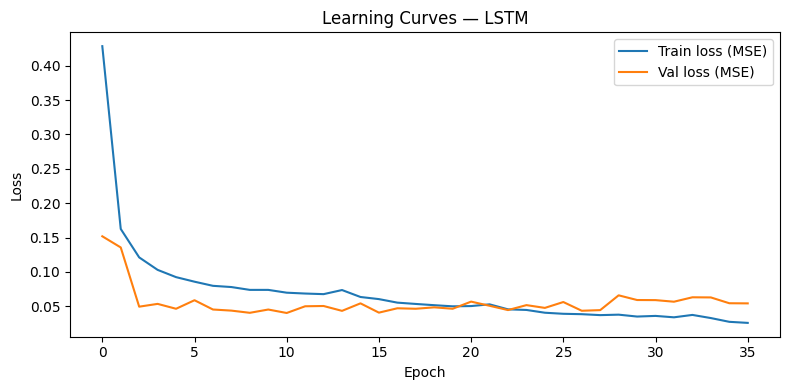

In [20]:
# Plot learning curves
plt.figure(figsize=(8,4))
plt.plot(history["train_loss"], label="Train loss (MSE)")
plt.plot(history["val_loss"], label="Val loss (MSE)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title(f"Learning Curves — {best_model_name.upper()}")
plt.legend()
plt.tight_layout()
plt.show()

Retrained on train+val for 11 epochs.
TEST metrics (REAL units): {'mse': 18810553.487702336, 'mae': 2473.611381651996, 'mape': 17.13556472814491, 'r2': 0.9718793564269775}


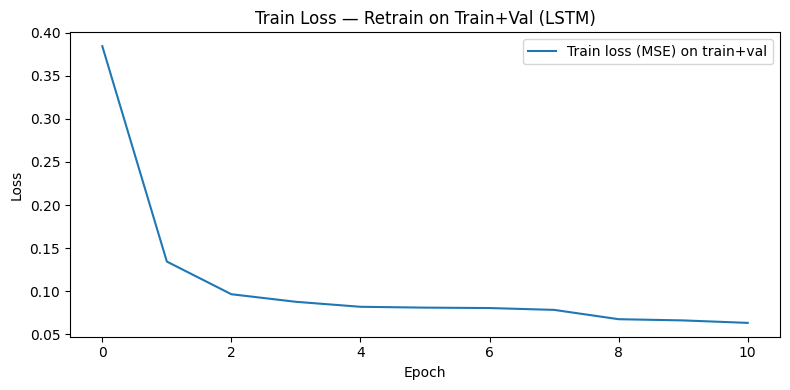

In [24]:
# Retrain on FULL (train + val), then evaluate on TEST
# We use the number of epochs learned above (best_epoch) so we don't need a val set.

full_train_dataset = torch.utils.data.ConcatDataset([
    TensorDataset(X_train_tensor, y_train_tensor),
    TensorDataset(X_val_tensor, y_val_tensor)
])

full_train_loader = DataLoader(full_train_dataset, batch_size=256, shuffle=True, drop_last=False)

full_model = build_model(best_model_name, input_size, output_size, best_hp)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(full_model.parameters(), lr=best_hp["lr"], weight_decay=best_hp["weight_decay"])

train_losses = []
epochs_to_train = max(1, best_epoch)  # best_epoch is 1-based

for epoch in range(1, epochs_to_train + 1):
    tr = train_one_epoch(full_model, full_train_loader, optimizer, criterion)
    train_losses.append(tr)

# Test metrics (REAL units)
test_pred_s, test_true_s = predict_loader(full_model, test_loader)

# Inverse transform to real units
y_pred = scaler_y.inverse_transform(test_pred_s.numpy().reshape(-1, 1)).reshape(test_pred_s.shape)
y_true = scaler_y.inverse_transform(test_true_s.numpy().reshape(-1, 1)).reshape(test_true_s.shape)

test_metrics_real = regression_metrics(y_true, y_pred)

print(f"Retrained on train+val for {epochs_to_train} epochs.")
print("TEST metrics (REAL units):", test_metrics_real)

# Plot learning curves
plt.figure(figsize=(8,4))
plt.plot(train_losses, label="Train loss (MSE) on train+val")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title(f"Train Loss — Retrain on Train+Val ({best_model_name.upper()})")
plt.legend()
plt.tight_layout()
plt.show()

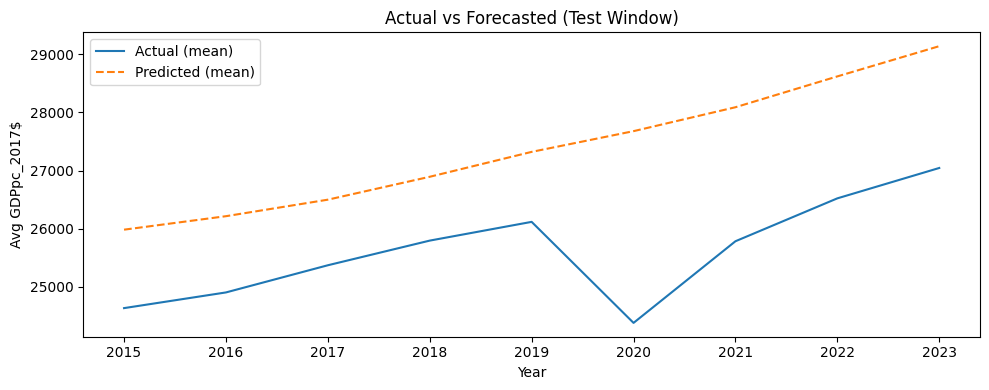

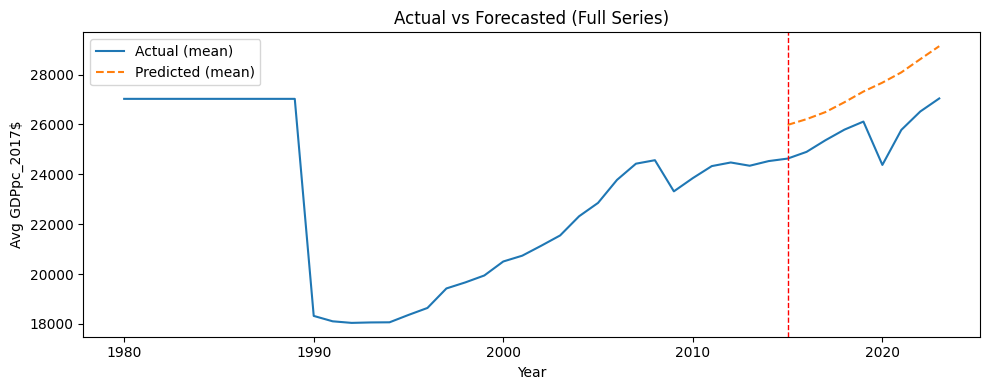

In [22]:
# Visualisation of the forecastings
# We build fuction to streamline this
def plot_forecast_two_charts(
    model,
    X_test_tensor,
    y_test_tensor,
    scaler_y,
    output_window,
    out_start_year_win,
    test_idx,
    world_bank_data,
    device=device
):
    model.eval()

    with torch.no_grad():
        y_pred_s = model(X_test_tensor.to(device)).cpu().numpy()   # (n_test, H)

    y_true_s = y_test_tensor.cpu().numpy()                         # (n_test, H)

    # Inverse scale
    y_pred = scaler_y.inverse_transform(y_pred_s.reshape(-1, 1)).reshape(y_pred_s.shape)
    y_true = scaler_y.inverse_transform(y_true_s.reshape(-1, 1)).reshape(y_true_s.shape)

    # Build years for each horizon in each window, then flatten
    out_start_test = out_start_year_win[test_idx]                  # (n_test,)
    years = out_start_test[:, None] + np.arange(output_window)     # (n_test, H)

    years_flat = years.reshape(-1)
    true_flat  = y_true.reshape(-1)
    pred_flat  = y_pred.reshape(-1)

    # Aggregate by year (mean)
    uniq_years = np.unique(years_flat)
    true_year = np.array([true_flat[years_flat == yr].mean() for yr in uniq_years])
    pred_year = np.array([pred_flat[years_flat == yr].mean() for yr in uniq_years])

    # Build full actual series
    actual_by_year = (
        world_bank_data[world_bank_data["year"] >= 1980]
          .groupby("year")["GDPpc_2017$"]
          .mean()
          .sort_index()
    )
    all_years = actual_by_year.index.to_numpy()
    actual_all = actual_by_year.to_numpy()

    # Predicted segment only
    pred_years = uniq_years
    pred_vals  = pred_year

    # Plot 1: only forecast window (2015-2023)
    plt.figure(figsize=(10, 4))
    plt.plot(uniq_years, true_year, label="Actual (mean)")
    plt.plot(uniq_years, pred_year, label="Predicted (mean)", linestyle='--')
    plt.xlabel("Year")
    plt.ylabel("Avg GDPpc_2017$")
    plt.title("Actual vs Forecasted (Test Window)")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Plot 2: full series + predicted tail
    plt.figure(figsize=(10, 4))
    plt.plot(all_years, actual_all, linestyle='-', label="Actual (mean)")
    plt.plot(pred_years, pred_vals, linestyle='--', label="Predicted (mean)")
    plt.axvline(pred_years.min(), linestyle='--', linewidth=1, color="red")
    plt.xlabel("Year")
    plt.ylabel("Avg GDPpc_2017$")
    plt.title("Actual vs Forecasted (Full Series)")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Use the model trained on train+val (full_model) for final reporting plots:
plot_forecast_two_charts(
    model=full_model,
    X_test_tensor=X_test_tensor,
    y_test_tensor=y_test_tensor,
    scaler_y=scaler_y,
    output_window=output_window,
    out_start_year_win=out_start_year_win,
    test_idx=test_idx,
    world_bank_data=world_bank_data
)